# Homework 4: Geometry of Learning
**Course:** Computational Data Mining

**Summary:**
This notebook explores optimization geometry and why we don't use Newton's method in Deep Learning.
1. **Math:** Visualizing GD (ZigZag) vs Newton (Direct) on a bad surface.
2. **Small Nets:** Showing L-BFGS is faster than SGD for small models.
3. **Deep Nets:** Calculating memory limits (RAM) for Hessian matrix.
4. **QR:** Using Orthogonality to fix data geometry and speed up SGD.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

## Part 1: Math Analysis.
Comparison of GD and Newton on a narrow valley function.

In [ ]:

# (Ill-conditioned)
H = np.array([[1.0, 0.0], [0.0, 50.0]])

def gradient(v):
    return H @ v

# Gradient Descent
def gd(start, lr=0.038, steps=20):
    path = [start]
    v = start
    for _ in range(steps):
        v = v - lr * gradient(v) # Formula: v - alpha * grad
        path.append(v)
    return np.array(path)

# Newton's Method
def newton(start):
    # Formula: v - H_inv * grad
    H_inv = np.linalg.inv(H)
    return np.array([start, start - H_inv @ gradient(start)])



In [ ]:
# Visualization
start = np.array([10.0, 1.0])
path_gd = gd(start)
path_newton = newton(start)



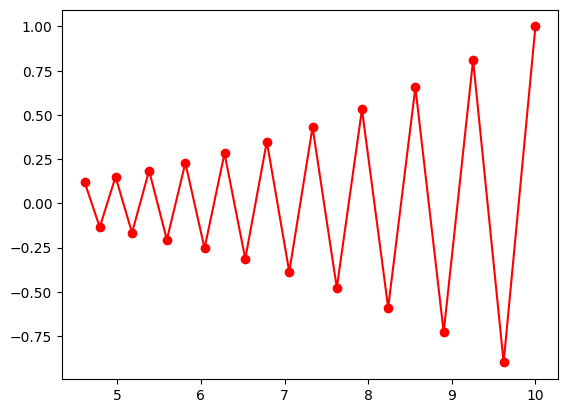

In [ ]:
plt.plot(path_gd[:,0], path_gd[:,1], 'r-o', label='GD')

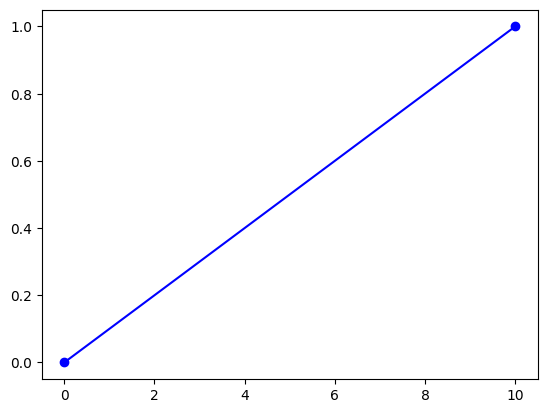

In [ ]:
plt.plot(path_newton[:,0], path_newton[:,1], 'b-o', label='Newton')

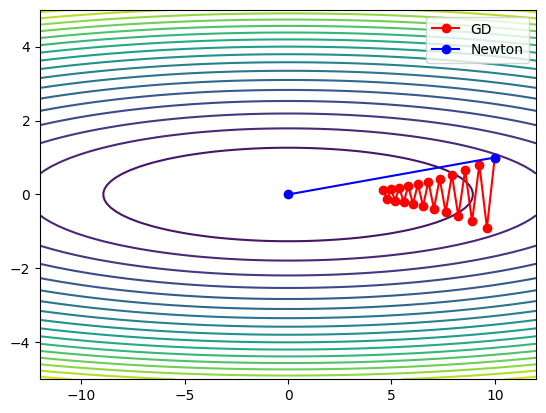

In [ ]:
# Plotting
x = np.linspace(-12, 12, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)
Z = 0.5 * (H[0,0]*X**2 + H[1,1]*Y**2)

plt.contour(X, Y, Z, levels=20)
plt.legend()
plt.show()

Result: GD moves zig-zag and slow. Newton goes direct to center in 1 step.

##Part 2: Shallow Network Test.
Using Breast Cancer dataset. Model is small (5 neurons).

In [13]:
import time
from sklearn.datasets import load_breast_cancer
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [16]:
# Load Data
data = load_breast_cancer()
X = StandardScaler().fit_transform(data.data)
y = data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
# Solvers to compare
solvers = ['sgd', 'lbfgs'] # lbfgs is Quasi-Newton

In [20]:
# Compet Start (Small Model)
for s in solvers:
    # Tiny model: 1 hidden layer with 5 neurons
    clf = MLPClassifier(hidden_layer_sizes=(5,), solver=s, max_iter=200, random_state=1)

    start = time.time()
    clf.fit(X_train, y_train)
    end = time.time()

    print(f"Optimizer: {s}")
    print(f"Time: {end-start:.4f}s")
    print(f"Acc: {clf.score(X_test, y_test):.4f}")
    print("---")

Optimizer: sgd
Time: 0.3581s
Acc: 0.9650
---
Optimizer: lbfgs
Time: 0.0314s
Acc: 0.9720
---


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Result: L-BFGS (Newton-based) is faster and better accuracy than SGD

## Part 3: The Memory Wall.
Calculating Hessian size for a Deep NN (MNIST).

In [22]:
# Deep Network Specs: 784 inputs -> 100 -> 100 -> 100 -> 10 outputs
# Calculating Parameters (N)
n_input = 784
n_hidden = 100
n_output = 10

# Weights + Biases count
N = (n_input*n_hidden + n_hidden) + \
    (n_hidden*n_hidden + n_hidden) + \
    (n_hidden*n_hidden + n_hidden) + \
    (n_hidden*n_output + n_output)

print(f"Total Parameters (N): {N}")

# Hessian Matrix Size is N x N
hessian_elements = N ** 2
hessian_memory_bytes = hessian_elements * 4 # 4 bytes per float
hessian_memory_gb = hessian_memory_bytes / (1024**3)

print(f"Hessian Matrix Size: {hessian_memory_gb:.2f} GB")

Total Parameters (N): 99710
Hessian Matrix Size: 37.04 GB



Result: We need 37GB RAM just for the matrix. Too big. => Pure Newton is impossible for deep nets (Memory Wall).

## Part 4: Orthogonality and QR.
Using QR decomposition to decorrelate features.

In [23]:
from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error

In [24]:

# Load Correlated Data
data = fetch_california_housing()
X = data.data[:1000]
y = data.target[:1000]

# Apply QR Decomposition to fix geometry
Q, R = np.linalg.qr(X)

In [25]:

# Train SGD on both
# Raw Data
model_raw = SGDRegressor(max_iter=50, eta0=1e-9, learning_rate='constant')
loss_raw = []
# QR Data
model_qr = SGDRegressor(max_iter=50, eta0=1e-2, learning_rate='constant')
loss_qr = []


In [26]:

# Training loop simulation
for i in range(50):
    model_raw.partial_fit(X, y)
    loss_raw.append(mean_squared_error(y, model_raw.predict(X)))

    model_qr.partial_fit(Q, y)
    loss_qr.append(mean_squared_error(y, model_qr.predict(Q)))


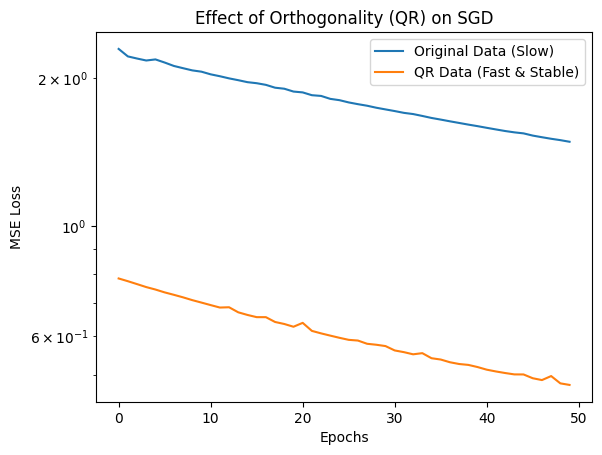

In [28]:
# Plot
plt.plot(loss_raw, label='Original Data (Slow)')
plt.plot(loss_qr, label='QR Data (Fast & Stable)')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.yscale('log')
plt.legend()
plt.title("Effect of Orthogonality (QR) on SGD")
plt.show()

Result: Training on Q (orthogonal) is much faster and stable than original X.(Geometry matters)